# Experimentación - STConv



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import STConvModel
from utils.trainer import  TrainerSTConv
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [13]:
def entrenar_y_evaluar_modelos_stconv(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = device
    n_iter = 50  
    for _ in tqdm(range(n_iter)):
        # Selecciona aleatoriamente los parámetros
        out_channels = random.choice(param_grid["out_channels"])
        kernel_size = random.choice(param_grid["kernel_size"])
        hidden_channels = random.choice(param_grid["hidden_channels"])
        normalization = random.choice(param_grid["normalization"])
       
        print(f"Entrenando modelo con out_channels={out_channels}, kernel_size={kernel_size}, hidden_channels={hidden_channels}, normalization={normalization}")
        model = STConvModel(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=out_channels,k=2, kernel_size=kernel_size, hidden_channels=hidden_channels, normalization=normalization, is_classification=True)
        
        trainer = TrainerSTConv(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Out channels": out_channels,
            "Kernel size": kernel_size,
            "Hidden channels": hidden_channels,
            "Normalization": normalization,
            "Loss_final": losses[-1],  
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
    
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {"Out channels": out_channels, "Kernel size": kernel_size, "Hidden channels": hidden_channels, "Normalization": normalization}

            mejores_resultados = results_intermedio

        print("Resultados: ", resultados_list[-1])
        
    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [8]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import STConvModel

In [11]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerSTConv

In [16]:
param_grid = {
    "out_channels": [32, 64],
    "kernel_size": [3,5,7],
    "normalization": ["sym", "rw"],
    "hidden_channels": [16, 32, 64],
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_stconv(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "STConv",target_names)

  0%|          | 0/50 [00:00<?, ?it/s]

Entrenando modelo con out_channels=64, kernel_size=7, hidden_channels=64, normalization=rw

==================== DATASET INFO ===================

Train dataset: 384
Validation dataset: 82
Test dataset: 83

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5577 | Eval Loss: 1.4872 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | F1-Score: 0.1097 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5116 | Eval Loss: 1.4354 | Accuracy: 0.5366 | Precision: 0.2215 | Recall: 0.3529 | F1-Score: 0.2696 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.4801 | Eval Loss: 1.3981 | Accuracy: 0.5610 | Precision: 0.2254 | Recall: 0.3818 | F1-Score: 0.2834 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.4665 | Eval Loss: 1.3807 | Accuracy: 0.5732 | Precision: 0.2338 | Recall: 0.3882 | F1-Score: 0.2914 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.4564 | Eval Loss: 1.3686 | Accuracy: 0.5610 | Precision: 0.2276 | Recall: 0.3818 | F1-Score: 0.2850 | LR: 0.0010 | 
Epoch 6/100 | Train 

  2%|▏         | 1/50 [14:16:58<699:52:00, 51418.79s/it]

              precision    recall  f1-score   support

           0       0.30      0.82      0.44        11
           1       0.52      0.73      0.61        15
           2       0.67      0.22      0.33         9
           3       0.00      0.00      0.00        19
           4       0.72      0.72      0.72        29

    accuracy                           0.52        83
   macro avg       0.44      0.50      0.42        83
weighted avg       0.46      0.52      0.46        83

preds:  torch.Size([])
test loss: 1.445542, test accuracy: 0.5181, test precision: 0.4429, test recall: 0.4996, test F1-score: 0.4215
Resultados:  {'Out channels': 64, 'Kernel size': 7, 'Hidden channels': 64, 'Normalization': 'rw', 'Loss_final': 1.3076761960983276, 'Accuracy_eval': 0.5992026266416511, 'Precision_eval': 0.3700127324970248, 'Recall_eval': 0.43336885126258945, 'F1_eval': 0.35672511372610255, 'Loss_eval': 1.37605881690979, 'Loss_tst': 1.4455422163009644, 'Accuracy_tst': 0.5180722891566265, 'Pr

  4%|▍         | 2/50 [35:08:59<871:28:49, 65361.03s/it]

              precision    recall  f1-score   support

           0       0.28      0.73      0.40        11
           1       0.73      0.73      0.73        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.77      0.93      0.84        29

    accuracy                           0.58        83
   macro avg       0.46      0.52      0.46        83
weighted avg       0.49      0.58      0.51        83

preds:  torch.Size([])
test loss: 1.444225, test accuracy: 0.5783, test precision: 0.4561, test recall: 0.5228, test F1-score: 0.4570
Resultados:  {'Out channels': 32, 'Kernel size': 7, 'Hidden channels': 64, 'Normalization': 'sym', 'Loss_final': 1.296454906463623, 'Accuracy_eval': 0.6228893058161352, 'Precision_eval': 0.4165571582617609, 'Recall_eval': 0.47969469177249063, 'F1_eval': 0.39280360409807213, 'Loss_eval': 1.365902066230774, 'Loss_tst': 1.4442253112792969, 'Accuracy_tst': 0.5783132530120482, 'P

  6%|▌         | 3/50 [42:52:56<629:37:41, 48226.85s/it]

              precision    recall  f1-score   support

           0       0.43      0.82      0.56        11
           1       0.52      0.73      0.61        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.70      0.97      0.81        29

    accuracy                           0.58        83
   macro avg       0.33      0.50      0.40        83
weighted avg       0.40      0.58      0.47        83

preds:  torch.Size([])
test loss: 1.377444, test accuracy: 0.5783, test precision: 0.3305, test recall: 0.5034, test F1-score: 0.3970
Resultados:  {'Out channels': 32, 'Kernel size': 5, 'Hidden channels': 32, 'Normalization': 'rw', 'Loss_final': 1.291947841644287, 'Accuracy_eval': 0.5823170731707317, 'Precision_eval': 0.33255012377797677, 'Recall_eval': 0.41901571546732835, 'F1_eval': 0.34020440455722034, 'Loss_eval': 1.286113977432251, 'Loss_tst': 1.377443552017212, 'Accuracy_tst': 0.5783132530120482, 'Pr

  8%|▊         | 4/50 [51:06:32<522:20:46, 40879.27s/it]

              precision    recall  f1-score   support

           0       0.29      0.91      0.44        11
           1       0.80      0.53      0.64        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.72      0.97      0.82        29

    accuracy                           0.55        83
   macro avg       0.36      0.48      0.38        83
weighted avg       0.43      0.55      0.46        83

preds:  torch.Size([])
test loss: 1.424784, test accuracy: 0.5542, test precision: 0.3624, test recall: 0.4816, test F1-score: 0.3816
Resultados:  {'Out channels': 32, 'Kernel size': 3, 'Hidden channels': 32, 'Normalization': 'sym', 'Loss_final': 1.2949799299240112, 'Accuracy_eval': 0.598499061913696, 'Precision_eval': 0.33975347486871615, 'Recall_eval': 0.4396920157641219, 'F1_eval': 0.3594776199142314, 'Loss_eval': 1.3362722396850586, 'Loss_tst': 1.4247835874557495, 'Accuracy_tst': 0.5542168674698795, 'P

 10%|█         | 5/50 [59:02:59<455:34:57, 36446.60s/it]

              precision    recall  f1-score   support

           0       0.39      0.82      0.53        11
           1       0.56      0.67      0.61        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.68      0.97      0.80        29

    accuracy                           0.57        83
   macro avg       0.33      0.49      0.39        83
weighted avg       0.39      0.57      0.46        83

preds:  torch.Size([])
test loss: 1.371745, test accuracy: 0.5663, test precision: 0.3260, test recall: 0.4901, test F1-score: 0.3871
Resultados:  {'Out channels': 32, 'Kernel size': 5, 'Hidden channels': 16, 'Normalization': 'rw', 'Loss_final': 1.28294837474823, 'Accuracy_eval': 0.5827861163227017, 'Precision_eval': 0.2929614659462833, 'Recall_eval': 0.42394759889067285, 'F1_eval': 0.33759347851682703, 'Loss_eval': 1.29389488697052, 'Loss_tst': 1.371745228767395, 'Accuracy_tst': 0.5662650602409639, 'Preci

 12%|█▏        | 6/50 [74:31:02<525:23:52, 42987.10s/it]

              precision    recall  f1-score   support

           0       0.36      0.82      0.50        11
           1       0.73      0.73      0.73        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.77      0.93      0.84        29

    accuracy                           0.57        83
   macro avg       0.37      0.50      0.42        83
weighted avg       0.45      0.57      0.49        83

preds:  torch.Size([])
test loss: 1.398409, test accuracy: 0.5663, test precision: 0.3730, test recall: 0.4965, test F1-score: 0.4154
Resultados:  {'Out channels': 64, 'Kernel size': 3, 'Hidden channels': 16, 'Normalization': 'rw', 'Loss_final': 1.2760146856307983, 'Accuracy_eval': 0.6179643527204502, 'Precision_eval': 0.4026154188927367, 'Recall_eval': 0.47663674402763595, 'F1_eval': 0.3996931001145, 'Loss_eval': 1.3113830089569092, 'Loss_tst': 1.3984088897705078, 'Accuracy_tst': 0.5662650602409639, 'Prec

 14%|█▍        | 7/50 [86:10:23<509:26:59, 42651.62s/it]

              precision    recall  f1-score   support

           0       0.30      0.82      0.44        11
           1       0.52      0.73      0.61        15
           2       0.67      0.22      0.33         9
           3       0.00      0.00      0.00        19
           4       0.72      0.72      0.72        29

    accuracy                           0.52        83
   macro avg       0.44      0.50      0.42        83
weighted avg       0.46      0.52      0.46        83

preds:  torch.Size([])
test loss: 1.445542, test accuracy: 0.5181, test precision: 0.4429, test recall: 0.4996, test F1-score: 0.4215
Resultados:  {'Out channels': 64, 'Kernel size': 7, 'Hidden channels': 64, 'Normalization': 'rw', 'Loss_final': 1.3076761960983276, 'Accuracy_eval': 0.5992026266416511, 'Precision_eval': 0.3700127324970248, 'Recall_eval': 0.43336885126258945, 'F1_eval': 0.35672511372610255, 'Loss_eval': 1.37605881690979, 'Loss_tst': 1.4455422163009644, 'Accuracy_tst': 0.5180722891566265, 'Pr

 16%|█▌        | 8/50 [94:27:35<449:59:23, 38570.56s/it]

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.00      0.00      0.00        15
           2       0.40      0.22      0.29         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.46        83
   macro avg       0.29      0.37      0.31        83
weighted avg       0.28      0.46      0.33        83

preds:  torch.Size([])
test loss: 1.432909, test accuracy: 0.4578, test precision: 0.2938, test recall: 0.3717, test F1-score: 0.3052
Resultados:  {'Out channels': 64, 'Kernel size': 7, 'Hidden channels': 32, 'Normalization': 'sym', 'Loss_final': 1.4086891412734985, 'Accuracy_eval': 0.5741088180112571, 'Precision_eval': 0.294091990900564, 'Recall_eval': 0.3916888045540797, 'F1_eval': 0.30723513946586356, 'Loss_eval': 1.3391014337539673, 'Loss_tst': 1.4329092502593994, 'Accuracy_tst': 0.4578313253012048, 'P

 18%|█▊        | 9/50 [119:48:16<626:47:59, 55036.08s/it]

              precision    recall  f1-score   support

           0       0.27      0.82      0.41        11
           1       0.82      0.60      0.69        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.74      0.97      0.84        29

    accuracy                           0.55        83
   macro avg       0.37      0.48      0.39        83
weighted avg       0.44      0.55      0.47        83

preds:  torch.Size([])
test loss: 1.423963, test accuracy: 0.5542, test precision: 0.3656, test recall: 0.4767, test F1-score: 0.3874
Resultados:  {'Out channels': 64, 'Kernel size': 5, 'Hidden channels': 32, 'Normalization': 'sym', 'Loss_final': 1.2776970863342285, 'Accuracy_eval': 0.6165572232645403, 'Precision_eval': 0.39406359440693134, 'Recall_eval': 0.46719116430691376, 'F1_eval': 0.3867348685553196, 'Loss_eval': 1.3217661380767822, 'Loss_tst': 1.4239627122879028, 'Accuracy_tst': 0.5542168674698795, 

 20%|██        | 10/50 [251:59:16<2055:02:06, 184953.17s/it]

              precision    recall  f1-score   support

           0       0.29      0.91      0.44        11
           1       0.80      0.53      0.64        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.72      0.97      0.82        29

    accuracy                           0.55        83
   macro avg       0.36      0.48      0.38        83
weighted avg       0.43      0.55      0.46        83

preds:  torch.Size([])
test loss: 1.422145, test accuracy: 0.5542, test precision: 0.3624, test recall: 0.4816, test F1-score: 0.3816
Resultados:  {'Out channels': 32, 'Kernel size': 3, 'Hidden channels': 32, 'Normalization': 'rw', 'Loss_final': 1.2998621463775635, 'Accuracy_eval': 0.6050656660412759, 'Precision_eval': 0.3299930058992381, 'Recall_eval': 0.4480834914611005, 'F1_eval': 0.36560997303472054, 'Loss_eval': 1.337524652481079, 'Loss_tst': 1.4221454858779907, 'Accuracy_tst': 0.5542168674698795, 'Pr

 22%|██▏       | 11/50 [260:00:51<1486:14:20, 137191.30s/it]

              precision    recall  f1-score   support

           0       0.29      0.82      0.43        11
           1       0.82      0.60      0.69        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.74      0.97      0.84        29

    accuracy                           0.55        83
   macro avg       0.37      0.48      0.39        83
weighted avg       0.44      0.55      0.47        83

preds:  torch.Size([])
test loss: 1.421972, test accuracy: 0.5542, test precision: 0.3691, test recall: 0.4767, test F1-score: 0.3913
Resultados:  {'Out channels': 64, 'Kernel size': 5, 'Hidden channels': 32, 'Normalization': 'rw', 'Loss_final': 1.2770963907241821, 'Accuracy_eval': 0.6139774859287056, 'Precision_eval': 0.37620678363996163, 'Recall_eval': 0.46170559042475545, 'F1_eval': 0.3818851550747284, 'Loss_eval': 1.3205134868621826, 'Loss_tst': 1.4219720363616943, 'Accuracy_tst': 0.5542168674698795, '

 22%|██▏       | 11/50 [263:42:20<934:57:24, 86303.70s/it]  


KeyboardInterrupt: 


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.92      0.73      0.81        15
           2       0.00      0.00      0.00         9
           3       0.95      1.00      0.97        19
           4       0.85      1.00      0.92        29

    accuracy                           0.84        83
   macro avg       0.67      0.75      0.70        83
weighted avg       0.77      0.84      0.80        83

preds:  torch.Size([])
test loss: 1.064711, test accuracy: 0.8434, test precision: 0.6733, test recall: 0.7467, test F1-score: 0.6991


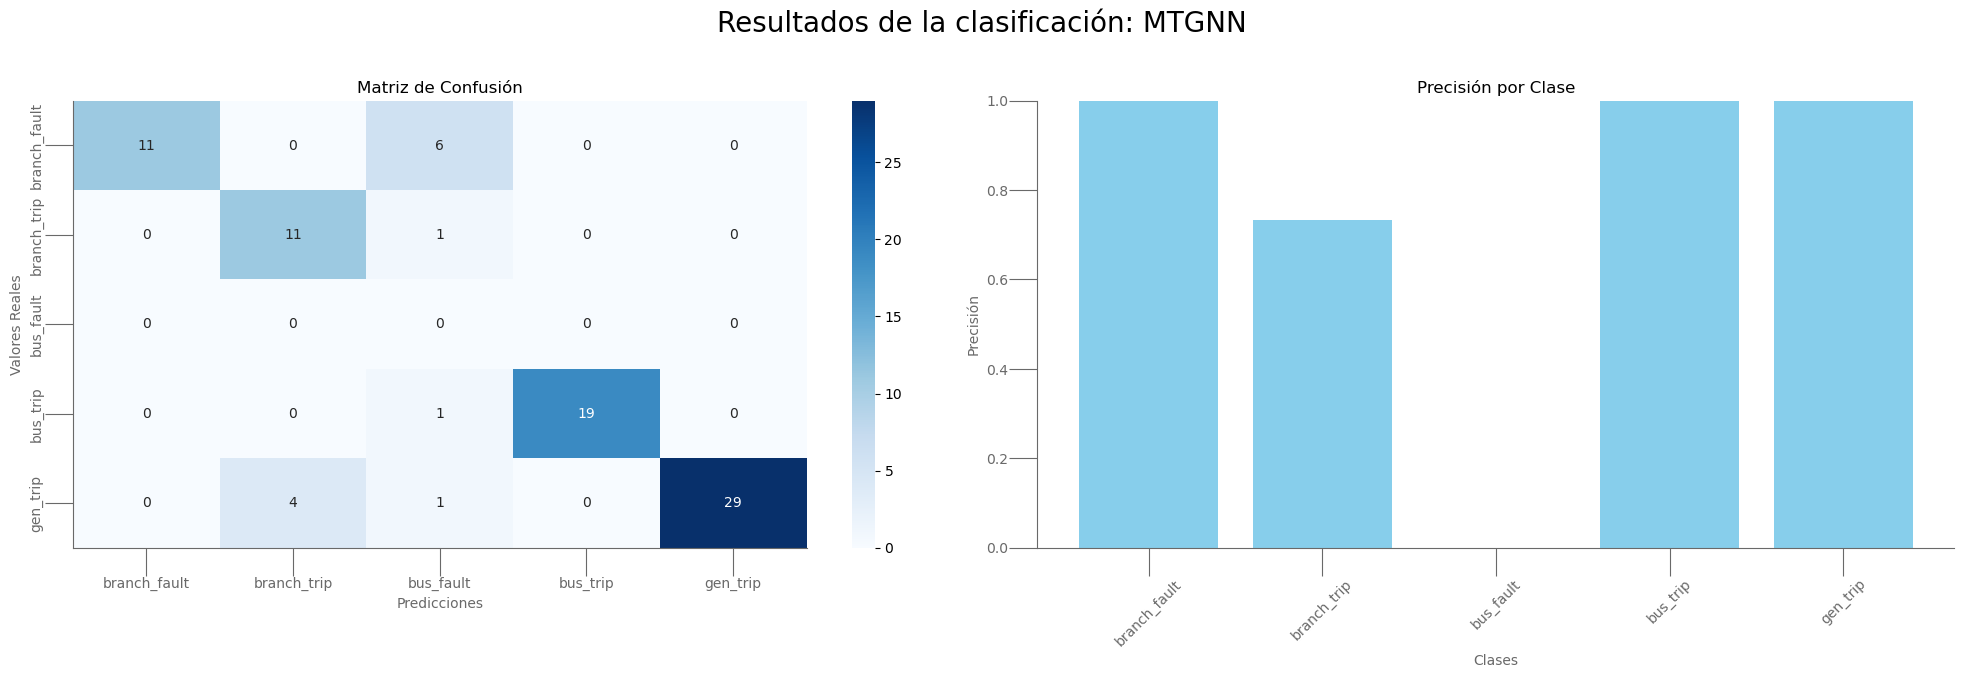

In [ ]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "MTGNN")

In [15]:
name_model ="MTGNN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0     MPNN_LSTM                {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH                  {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH                  {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN             {'hidden': 50, 'Embedding': 5, 'K': 2}   
4   DyGrEncoder  {'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_o...   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_...   
6         DCRNN                                     {'hidden': 60}   
7         MTGNN  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_...   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841 